# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [15]:
churn.columns

Index(['CUST_ID', 'ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'CFU',
       'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'BYO_PLAN_STATUS', 'PLAN_TENURE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'CONTRACT_STATUS', 'PREV_CONTRACT_DURATION', 'HANDSET_USED_BRAND',
       'CHURN_IND', 'MONTHLY_SPEND', 'COUNTRY_METRO_REGION', 'STATE',
       'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'],
      dtype='object')

In [16]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46130 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

In [21]:
churn.isnull().values.any()

True

In [19]:
print(churn.isnull().sum())

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64


Since there is Missing values in 76 rows in the AGE column, missing value treatment will be done for those. Nearly 40% of the RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH & RECON_EMAIL_NEXT_MTH values are Null and so these columns will not be used for the prediction.

In [24]:
churn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CUST_ID,46206.0,42335.196879,22100.432751,1.00,24951.75,43261.00,61132.75,79500.00
ACCOUNT_TENURE,46206.0,45.874627,33.077927,0.00,14.00,44.00,77.00,120.00
ACCT_CNT_SERVICES,46206.0,1.555707,0.835529,1.00,1.00,1.00,2.00,4.00
AGE,46130.0,41.411836,15.263726,-4.00,28.00,40.00,52.00,116.00
SERVICE_TENURE,46206.0,50.318617,51.925537,0.00,11.00,35.00,69.00,259.00
PLAN_ACCESS_FEE,46206.0,51.364858,20.855419,8.18,36.36,54.54,72.72,234.54
PLAN_TENURE,46206.0,10.846708,9.769887,0.00,3.00,8.00,16.00,147.00
MONTHS_OF_CONTRACT_REMAINING,46206.0,8.237112,8.341476,0.00,0.00,7.00,16.00,24.00
LAST_FX_CONTRACT_DURATION,46206.0,20.349825,8.034631,0.00,24.00,24.00,24.00,36.00
PREV_CONTRACT_DURATION,46206.0,15.249968,10.982958,0.00,0.00,24.00,24.00,36.00


In [25]:
# CREATE A FILTER VERSION OF DATA SET
churn_filter = churn.drop(labels=["RECON_SMS_NEXT_MTH","RECON_TELE_NEXT_MTH","RECON_EMAIL_NEXT_MTH"], axis=1)

In [27]:
churn_filter = churn_filter[churn_filter['AGE']>=0]

In [28]:
churn_filter[churn_filter['AGE'] < 0]['AGE'].count()

0

In [29]:
churn_filter=churn_filter[churn_filter.COUNTRY_METRO_REGION.notnull()] 
churn_filter=churn_filter[churn_filter.STATE.notnull()] 
churn_filter.count()

CUST_ID                         46127
ACCOUNT_TENURE                  46127
ACCT_CNT_SERVICES               46127
AGE                             46127
CFU                             46127
SERVICE_TENURE                  46127
PLAN_ACCESS_FEE                 46127
BYO_PLAN_STATUS                 46127
PLAN_TENURE                     46127
MONTHS_OF_CONTRACT_REMAINING    46127
LAST_FX_CONTRACT_DURATION       46127
CONTRACT_STATUS                 46127
PREV_CONTRACT_DURATION          46127
HANDSET_USED_BRAND              46127
CHURN_IND                       46127
MONTHLY_SPEND                   46127
COUNTRY_METRO_REGION            46127
STATE                           46127
dtype: int64

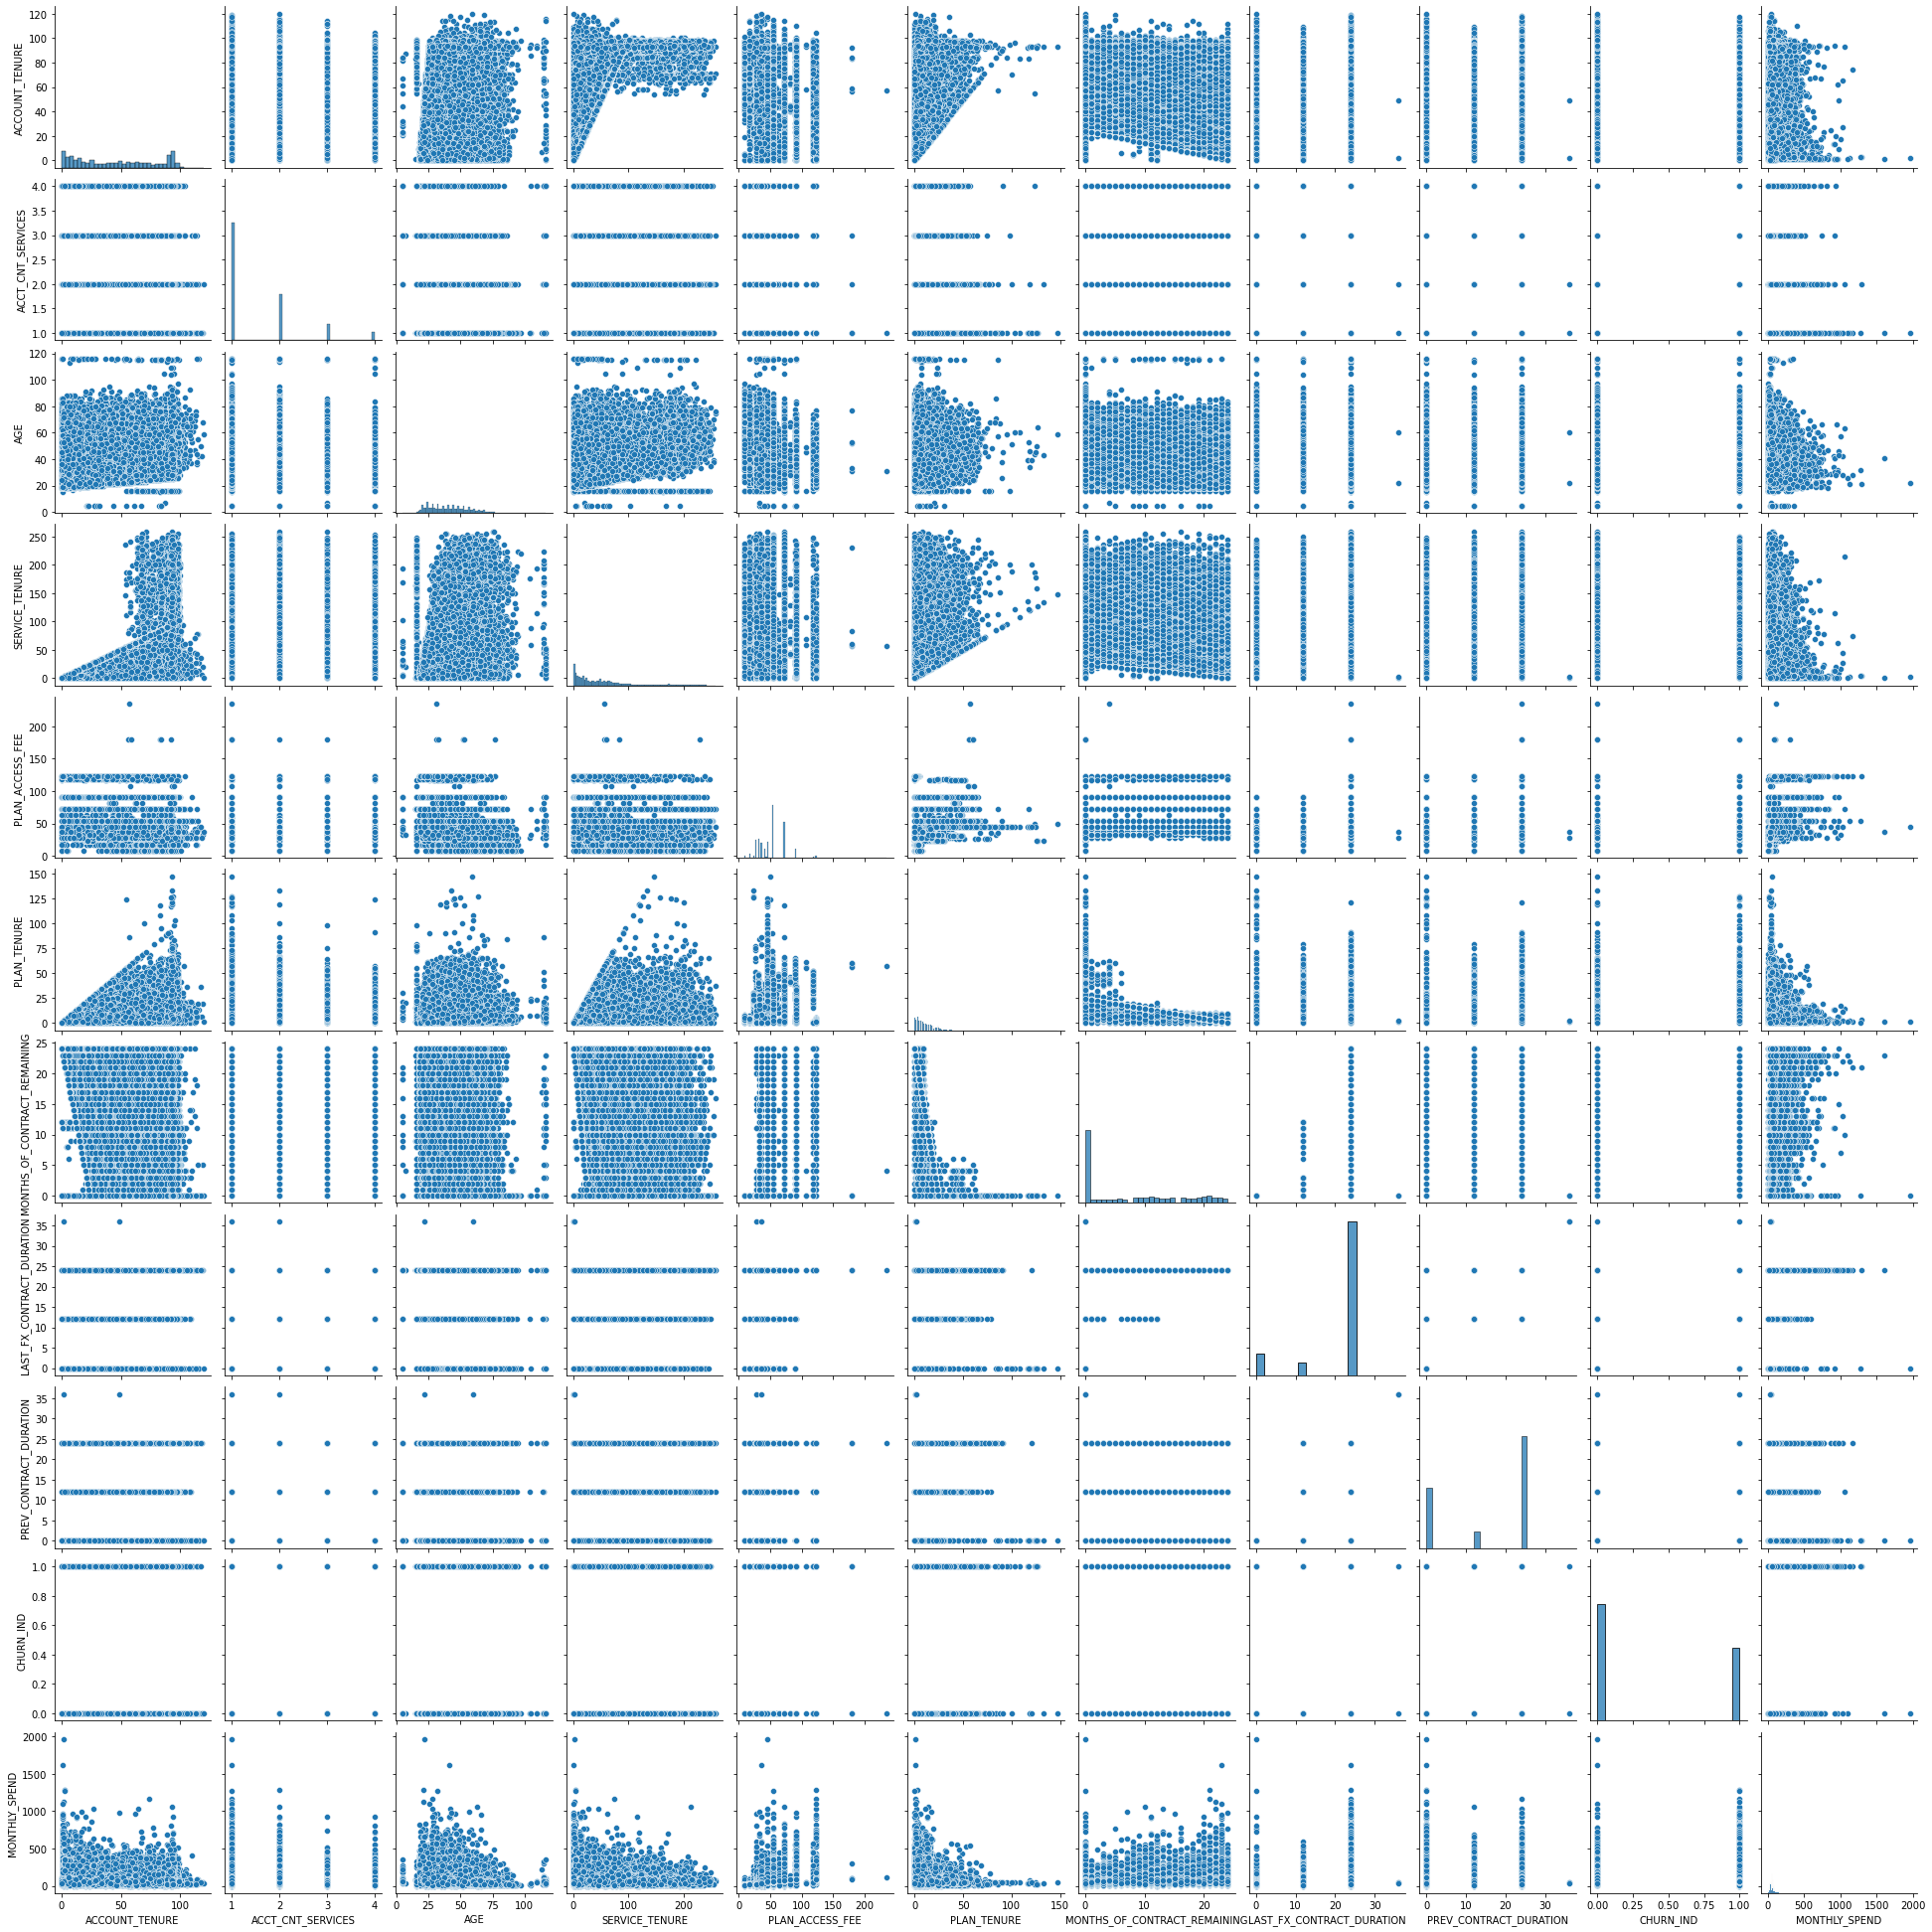

In [31]:
# DRAWING A PAIR-PLOT FOR ALL ATTRIBUTES EXCEPT THE 1ST COLUMN,'CUST_ID'
sns.pairplot(churn_filter.iloc[:,1:])

In [34]:
churn_filter.iloc[:,1:].corr()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
ACCOUNT_TENURE,1.000000,0.197913,0.250559,0.792277,-0.084736,0.247495,-0.170542,0.177226,0.504281,-0.151812,-0.138259
ACCT_CNT_SERVICES,0.197913,1.000000,0.157473,0.069596,-0.003732,-0.041169,0.023126,0.001373,0.021832,-0.062352,-0.019340
AGE,0.250559,0.157473,1.000000,0.251750,-0.347297,0.053682,-0.185673,-0.143433,0.008339,-0.115242,-0.209441
SERVICE_TENURE,0.792277,0.069596,0.251750,1.000000,-0.078511,0.218010,-0.143773,0.139667,0.411052,-0.153827,-0.115689
PLAN_ACCESS_FEE,-0.084736,-0.003732,-0.347297,-0.078511,1.000000,-0.058188,0.470619,0.393498,0.135902,-0.036616,0.448546
PLAN_TENURE,0.247495,-0.041169,0.053682,0.218010,-0.058188,1.000000,-0.429862,0.125981,0.184041,0.141735,-0.058086
MONTHS_OF_CONTRACT_REMAINING,-0.170542,0.023126,-0.185673,-0.143773,0.470619,-0.429862,1.000000,0.423933,-0.009677,-0.247336,0.302305
LAST_FX_CONTRACT_DURATION,0.177226,0.001373,-0.143433,0.139667,0.393498,0.125981,0.423933,1.000000,0.521031,-0.066558,0.218659
PREV_CONTRACT_DURATION,0.504281,0.021832,0.008339,0.411052,0.135902,0.184041,-0.009677,0.521031,1.000000,-0.064081,-0.010823
CHURN_IND,-0.151812,-0.062352,-0.115242,-0.153827,-0.036616,0.141735,-0.247336,-0.066558,-0.064081,1.000000,0.188309


It is evident from the plots above:
   ACCOUNT_TENURE & SERVICE_TENURE are highly correlated
   ACCOUNT_TENURE & PREV_CONTRACT_DURATION are moderately correlated
   SERVICE_TENURE & PREV_CONTRACT_DURATION are moderately correlated
   MONTHS_OF_CONTRACT_REMAINING	& PLAN_ACCESS_FEE are moderately correlated
   MONTHLY_SPEND & PLAN_ACCESS_FEE are moderately correlated